In [10]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('/Users/yangpei/Desktop/tensorflow/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,:'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/Users/yangpei/Desktop/tensorflow/data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

print(all_categories)
n_categories = len(all_categories)

['/Users/yangpei/Desktop/tensorflow/data/names/Czech.txt', '/Users/yangpei/Desktop/tensorflow/data/names/German.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Arabic.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Japanese.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Chinese.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Vietnamese.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Russian.txt', '/Users/yangpei/Desktop/tensorflow/data/names/French.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Irish.txt', '/Users/yangpei/Desktop/tensorflow/data/names/English.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Spanish.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Greek.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Italian.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Portuguese.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Scottish.txt', '/Users/yangpei/Desktop/tensorflow/data/names/Dutch.txt', '/Users/yangpei/Desktop/tensorflow/data/na

In [9]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1.0
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor("J"))
print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9166, -2.9268, -3.0216, -2.9204, -2.9132, -2.8449, -2.9906,
         -2.8606, -2.8842, -2.8243, -2.9033, -2.9095, -2.8453, -2.8159,
         -2.8853, -2.8776, -2.9092, -2.8042]])


In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 17)


In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, ' / line = ', line)

category =  Portuguese  / line =  Rocha
category =  Dutch  / line =  Lucassen
category =  Korean  / line =  Bang
category =  English  / line =  Karras
category =  Japanese  / line =  Isobe
category =  Chinese  / line =  Liu
category =  Scottish  / line =  Mckenzie
category =  German  / line =  Gutermuth
category =  Russian  / line =  Jeltyannikov
category =  Portuguese  / line =  Albuquerque


In [15]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 1.8810 Jang / Korean ✓
10000 10% (0m 10s) 1.4357 Luu / Chinese ✗ (Vietnamese)
15000 15% (0m 15s) 0.3389 Kasaya / Japanese ✓
20000 20% (0m 20s) 1.3893 Janvier / French ✓
25000 25% (0m 25s) 0.7659 Suk / Korean ✓
30000 30% (0m 30s) 0.1701 Ardiccioni / Italian ✓
35000 35% (0m 35s) 1.0116 Romeijnsen / Dutch ✓
40000 40% (0m 40s) 2.4627 Smith / German ✗ (Czech)
45000 45% (0m 45s) 0.7300 Castro / Portuguese ✓
50000 50% (0m 50s) 0.8851 Pan / Chinese ✓
55000 55% (0m 55s) 2.1458 Kirwin / Russian ✗ (English)
60000 60% (1m 0s) 1.1279 Wasem / Arabic ✓
65000 65% (1m 5s) 1.7070 Stepan / English ✗ (Czech)
70000 70% (1m 10s) 0.7117 Diep / Vietnamese ✓
75000 75% (1m 16s) 0.6387 Guan / Chinese ✓
80000 80% (1m 21s) 0.8339 Arian / Arabic ✓
85000 85% (1m 26s) 1.9324 Nam / Vietnamese ✗ (Korean)
90000 90% (1m 32s) 1.6041 Hirsch / Scottish ✗ (German)
95000 95% (1m 38s) 1.5203 Cha / Vietnamese ✗ (Korean)
100000 100% (1m 47s) 3.3305 Samuel / Arabic ✗ (French)


In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

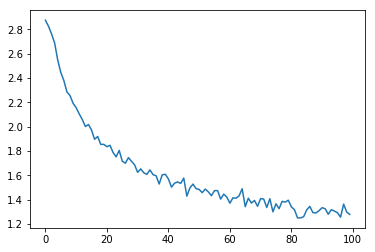

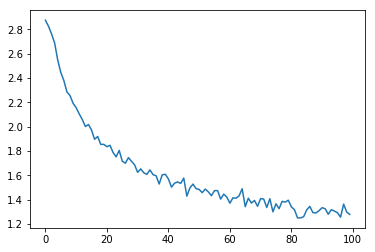

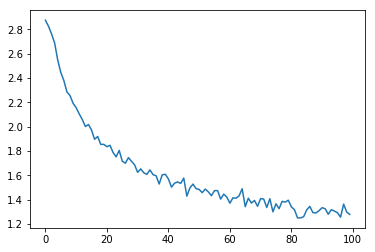

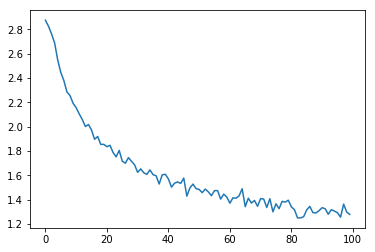

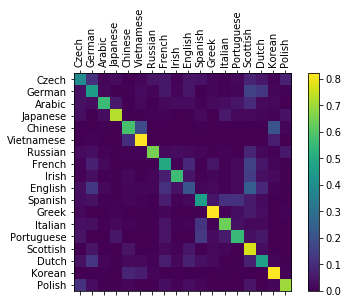

In [23]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()